In [32]:
from numpy.fft import fftn, fftfreq
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
import sys

In [33]:
import astropy.cosmology
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u

arcmin = 2.908882086656e-4 # [rad] ... PI / 180 / 60 //
arcsec = 4.848136811094e-6 # [rad] ... arcmin / 60 //

def arcsec_to_cMpc(l_arcsec, z):
    l_rad = l_arcsec * u.arcsec / u.radian
    l_cMpc = ( cosmo.comoving_transverse_distance(z) * l_rad ).to(u.Mpc)
    return l_cMpc.value 

def freq_to_comdis(nu_obs, nu_rest):
    z = nu_rest / nu_obs - 1
    if z < 0:
        print("Error: z < 0")
        sys.exit(1)
    return cosmo.comoving_distance(z).to(u.Mpc).value

freq_rest_dict = {
    "CO(1-0)": 115.271,
    "CO(2-1)": 230.538,
    "CO(3-2)": 345.796,
    "CO(4-3)": 461.041,
    "CO(5-4)": 576.268,
    "CO(6-5)": 691.473,
    "CO(7-6)": 806.652,
    "CO(8-7)": 921.800,
    "CO(9-8)": 1036.912,
    "CO(10-9)": 1151.985,
    "CO(11-10)": 1267.014,
    "CO(12-11)": 1381.995,
    "CO(13-12)": 1496.922,
    "[CII]158": 1900.537,
    "[OIII]88": 3393.006,
    "[NII]205": 1461.131,
    "[NII]122": 2459.381,
    "[CI](1-0)": 492.16065,
    "[CI](2-1)": 809.34197,
    "[OIII]5007": 5.997e4,
}
line_names = list(freq_rest_dict.keys())
NLINE = len(line_names)
print(line_names)

['CO(1-0)', 'CO(2-1)', 'CO(3-2)', 'CO(4-3)', 'CO(5-4)', 'CO(6-5)', 'CO(7-6)', 'CO(8-7)', 'CO(9-8)', 'CO(10-9)', 'CO(11-10)', 'CO(12-11)', 'CO(13-12)', '[CII]158', '[OIII]88', '[NII]205', '[NII]122', '[CI](1-0)', '[CI](2-1)', '[OIII]5007']


In [51]:
def load_data(data_dir=".", prefix="map", side_length=3600, fmin=200, fmax=300, dtheta=100, R=100, model=0, alpha=1):
    """
    load intensity data
    input:
        side_length: side length [arcsec]
        fmin: minimum frequency [GHz]
        fmax: maximum frequency [GHz]
        dtheta: angular resolution [arcsec]
        R: spectral resolution
    output:
        frequency: (Nf,) frequency [GHz]
        intensity: (Nx, Ny, Nf) intensity [Jy/sr]
        intensity_line: (Nline, Nx, Ny, Nf) intensity [Jy/sr]
    """

    fname_id = f"{data_dir}/{prefix}_{side_length}sec_fmin{fmin}_fmax{fmax}_angular{dtheta}_spectral{R}_model{model}_alpha{alpha}"

    fname = fname_id + ".h5"
    with h5py.File(fname, "r") as f:
        frequency = f["/frequency"][:] * 1e-9 # [GHz]
        intensity = f["/intensity"][:]
        if "nden" in fname:
            print("Total number: ", np.sum(intensity))
        
    shape = intensity.shape
    print("freqency shape: ", frequency.shape)
    print("intensity shape: ", intensity.shape)

    intensity_line = np.zeros((NLINE, shape[0], shape[1], shape[2]))
    for i in range(NLINE):
        with h5py.File(f"{fname_id}_{i}.h5", "r") as f:
            intensity_line[i] = f["/intensity"][:]
            if "nden" in fname:
                print(f"Total number {line_names[i]}: ", np.sum(intensity_line[i]))
            
    return frequency, intensity, intensity_line


def plot_mean(frequency, intensity, intensity_line, title=None, lines_to_show=line_names, ylim=None, nsmooth=1, logx=False):
    """
    plot mean intensity
    input: 
        frequency: (Nf+1,) frequency [GHz]
        intensity: (Nx, Ny, Nf) intensity [Jy/sr]
        intensity_line: (Nline, Nx, Ny, Nf) intensity [Jy/sr]
        title: title of the plot
        lines_to_show: list of line names to show
        ylim: y-axis limit
        nsmooth: smoothing scale
        logx: if True, use log scale for x-axis
    """

    plt.figure()
    plt.xlabel("Frequency [GHz]")
    plt.ylabel("Mean intensity [Jy/sr]")

    frequency_bin = 0.5 * (frequency[1:] + frequency[:-1])
    mean = np.mean(intensity, axis=(0, 1))
    if nsmooth > 1:
        mean = gaussian_filter(mean, sigma=nsmooth)
    plt.plot(frequency_bin, mean, color="k", label="total")

    count = 0
    for i in range(NLINE):
        if line_names[i] in lines_to_show:
            mean_line = np.mean(intensity_line[i], axis=(0, 1))
            if nsmooth > 1:
                mean_line = gaussian_filter(mean_line, sigma=nsmooth)

            ls = "-" if count < 10 else "--"
            plt.plot(frequency_bin, mean_line, ls=ls, label=f"{line_names[i]}")
            count += 1

    if len(lines_to_show) > 4:
        plt.legend(bbox_to_anchor=(1,1.1))
    else:
        plt.legend()
    plt.title(title)
    plt.ylim(ylim)
    plt.yscale("log")
    if logx:
        plt.xscale("log")
    
def show_map(frequency, intensity, intensity_line, side_length, lines_to_show=line_names, dy=1, use_log=False, smoothing=0):
    """
    show intensity map in x-z plane
    input:
        frequency: (Nf+1,) frequency [GHz]
        intensity: (Nx, Ny, Nf) intensity [Jy/sr]
        intensity_line: (Nline, Nx, Ny, Nf) intensity [Jy/sr]
        side_length: side length [arcsec]
        lines_to_show: list of line names to show
        use_log: if True, use log scale for intensity
        smoothing: smoothing scale
    """

    Nmap = len(lines_to_show) + 1
    line_ids = [line_names.index(name) for name in lines_to_show]

    plt.figure(figsize=(10, Nmap*2))
    plt.subplots_adjust(hspace=1)

    fmin = frequency[0]
    fmax = frequency[-1]

    def show_ticks(fmin=fmin, fmax=fmax, freq=frequency):
        if fmax - fmin < 150:
            tick_values = [ int(fmin/100) * 100 + 20*i for i in range(10) ]
        elif fmax - fmin > 10000:
            tick_values = [ int(fmin/10000) * 10000 + 2000*i for i in range(30) ]
        else:
            tick_values = [ int(fmin/100) * 100 + 100*i for i in range(10) ]
        tick_values = [v for v in tick_values if v > fmin and v < fmax]
        interpolator = interp1d(freq, np.arange(len(freq)))
        tick_positions = interpolator(tick_values)
        plt.xticks(ticks=tick_positions, labels=tick_values)

    def show_a_map(imap, map, side_length=side_length, iy=0, dy=1, vmin=None, vmax=None, label=None, use_log=use_log):
        plt.subplot2grid((Nmap,1), (imap,0))
        map_xz = map[:, iy:iy+dy, :].sum(axis=1)
        if use_log: map_xz = np.log10(map_xz)
        if smoothing > 0:
            map_xz = gaussian_filter(map_xz, sigma=smoothing)
        cmap = plt.cm.viridis
        cmap.set_bad(color=cmap(0))
        plt.imshow(map_xz, origin="lower", aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)
        plt.title(label)
        plt.colorbar(label="log I [Jy/sr]")
        plt.yticks([])
        x = side_length / 3600
        plt.ylabel("{:.1f} deg".format(x))
        plt.xlabel("frequency [GHz]")
        show_ticks()

    if dy < 0:
        dy = intensity.shape[1]
    print(f"Projection along y-axis: {dy:d} slices")
        
    show_a_map(0, intensity, dy=dy, label="total")
    for i, iline in enumerate(line_ids):
        show_a_map(i+1, intensity_line[iline], dy=dy, label=line_names[iline])

def my_fft(X, L=None, b=1.): # b = 2 * np.pi for inverse FT
    """
    Actually whatever dimension is ok
    input:
        X: (Nx, Ny, Nz) data 
        L: (3,) or float, box size
        b: normalization factor
    output:
        ft: (Nx, Ny, Nz) Fourier transform
        freq: (Nx, Ny, Nz) frequency
    """

    dim = len(X.shape)
    N = np.array(X.shape)

    if L is None:
        L = N
    elif np.isscalar(L):
        L = L * np.ones(dim)

    dx = np.array([float(l)/float(n) for l, n in zip(L, N)])
    Vx = np.product(dx) # volume of a cell

    freq = [fftfreq(n, d=d)*2*np.pi for n, d in zip(N, dx)]
    ft = Vx * fftn(X) * np.sqrt(1/np.abs(b)) ** dim
    
    return ft, freq

def calc_noise_power(sigma_noise_Jy_sr, freq, intensity, side_length=3600, line_name="CO(1-0)", with_hlittle=True):
       
    redshifts = freq_rest_dict[line_name] / freq - 1
    redshift_mean = np.mean(redshifts)
    nu_rest = freq_rest_dict[line_name]

    Lx = arcsec_to_cMpc(side_length, redshift_mean) # [cMpc/h]
    Ly = arcsec_to_cMpc(side_length, redshift_mean) # [cMpc/h]
    Lz = freq_to_comdis(freq[0], nu_rest) - freq_to_comdis(freq[-1], nu_rest) 

    dx = Lx / intensity.shape[0]
    dy = Ly / intensity.shape[1]
    dz = Lz / intensity.shape[2]
    
    dL = np.array([dx, dy, dz])

    hlittle = cosmo.H0.value / 100
    if with_hlittle:
        dL *= hlittle
    dV = np.prod(dL) 

    P_noise = sigma_noise_Jy_sr**2 * dV

    return P_noise


def calc_power(freq_obs, intensity, side_length=3600, line_name="CO(1-0)", dlogk=0.2, with_hlittle=True, logkpara_min=-10, logkperp_min=-10, sigma_noise=0): 
    """
    input:
        freq: (N,) frequency [GHz]
        intensity: (Nx, Ny, Nf) intensity [arbitrary unit]
        side_length: side length [arcsec]
        line_name: line name for which the distance is calculated
        dlogk: bin width for logk
        with_hlittle: if True, multiply h
        logkpara_min: minimum value of logkpara
        logkperp_min: minimum value of logkperp
    output:
        k: (Nk,) wavenumber [h/cMpc^-1]
        power1d: (Nk,) power spectrum [input unit^2 * (cMpc/h)^3]
    """
    
    redshifts = freq_rest_dict[line_name] / freq_obs - 1
    redshift_mean = np.mean(redshifts)
    nu_rest = freq_rest_dict[line_name]

    print(f"Use {line_name} rest-frame frequency")
    print(f"redshift: {redshifts[-1]:.2f} - {redshifts[0]:.2f} (mean: {redshift_mean:.2f})")
    
    Lx = arcsec_to_cMpc(side_length, redshift_mean) # [cMpc]
    Ly = arcsec_to_cMpc(side_length, redshift_mean) # [cMpc]
    Lz = freq_to_comdis(freq_obs[0], nu_rest) - freq_to_comdis(freq_obs[-1], nu_rest) # [cMpc]

    ## Fourier transform
    L = np.array([Lx, Ly, Lz])
    hlittle = cosmo.H0.value / 100
    if with_hlittle:
        L *= hlittle # [cMpc/h]
    V = np.prod(L) 
    
    ft, freq = my_fft(intensity, L=L)
    power_spectrum = np.abs(ft)**2 / V
    kx, ky, kz = np.meshgrid(freq[0], freq[1], freq[2], indexing='ij')

    ## noise power spectrum
    power_noise = calc_noise_power(sigma_noise, freq_obs, intensity, side_length=side_length, line_name=line_name, with_hlittle=with_hlittle)

    ## compute angular-averaged power spectrum
    logk = np.log10(np.sqrt(kx**2 + ky**2 + kz**2))
    logkpara = np.log10(np.abs(kz))
    logkperp = np.log10(np.sqrt(kx**2 + ky**2))
    
    logk_bins = np.arange(-1.4, 1.3, dlogk)#dk=k*dlogk
    
    power1d = np.zeros(len(logk_bins) - 1)
    power1d_err = np.zeros(len(logk_bins) - 1)
    for i in range(len(logk_bins) - 1):
        mask = (logk >= logk_bins[i]) & (logk < logk_bins[i+1]) & (logkpara > logkpara_min) & (logkperp > logkperp_min)
        Nk = mask.sum()

        if np.any(mask):
            power1d[i] = np.mean(power_spectrum[mask])
            power1d_err[i] = (power1d[i] + power_noise) / np.sqrt(Nk)

    return 10**(0.5*(logk_bins[1:]+logk_bins[:-1])), power1d, power1d_err

### Power spectrum

In [ ]:
data_dir = "./output_TNG300-1_model0"
side_length = 5400
dtheta = 27
with_hlittle = False

freq, intensity, intensity_line = load_data(data_dir=data_dir, prefix="nden_map" side_length=side_length, fmin=248, fmax=301, dtheta=dtheta, R=500, alpha=15)

sigma_noise = 1e-3 / (dtheta * arcsec)**2 # [Jy/sr]

## set frequency range 
freq = freq[20:70]
intensity = intensity[:,:,20:70]
intensity_line = intensity_line[:,:,:,20:70]

## compute power spectrum 
target_line = "[CII]158" ## conversions from [arcsec->cMpc] and [Hz->cMpc] are done for this line
k, power, power_err = calc_power(freq, intensity, side_length=side_length, line_name=target_line, with_hlittle=with_hlittle, sigma_noise=sigma_noise)
for i, l in enumerate(line_names):
    if l == target_line:
        k, power_line, power_line_err = calc_power(freq, intensity_line[i], side_length=side_length, line_name=l, with_hlittle=with_hlittle)
 
## mock observation with noise intensity
intensity_noise = np.random.normal(0, sigma_noise, intensity.shape)
intensity_w_noise = intensity + intensity_noise
k, power_w_noise, power_err_w_noise = calc_power(freq, intensity_w_noise, side_length=side_length, line_name=target_line, with_hlittle=with_hlittle)
power_noise_pred = calc_noise_power(sigma_noise, freq, intensity, side_length=side_length, line_name=target_line, with_hlittle=with_hlittle)

## plot power spectrum
plt.xscale("log")
plt.yscale("log")
plt.title(f"Frequency range: {freq[0]:.0f} - {freq[-1]:.0f} GHz")

#plt.errorbar(k, power_line, power_line_err,fmt='o',ecolor='black',markeredgecolor = "black",color='w')
plt.plot(k, power_line, label="[CII]")
plt.errorbar(k, power,power_err,fmt='o',ecolor='orange',markeredgecolor = "black",color='w')
plt.plot(k, power,  label="total power")

plt.plot(k, power_w_noise, label="observed (w/ noise)")
plt.plot(k, power_w_noise - power_noise_pred, label="observed (obs - predicted noise)")

if with_hlittle:
    plt.xlabel(r"$k \ [h\ \rm Mpc^{-1}]$")
    plt.ylabel(r"$P(k)\ [(Jy/sr)^2\ (cMpc/h)^3]$")
else:
    plt.xlabel(r"$k \ [\rm Mpc^{-1}]$") 
    plt.ylabel(r"$P(k)\ [(Jy/sr)^2\ \rm Mpc^3]$")

plt.legend()
#plt.savefig("3d_power_spectrum_b2_factor10_without_noise.png", bbox_inches="tight", pad_inches=0.0)

### Mean intensity

In [16]:
data_dir = "./output_TNG300-1"
freq, intensity, intensity_line = load_data(data_dir=data_dir, prefix="map", side_length=5400, fmin=100, fmax=1000, dtheta=27, R=20)
plot_mean(freq, intensity, intensity_line, lines_to_show=["CO(1-0)", "CO(2-1)", "CO(3-2)", "CO(4-3)", "CO(5-4)", "CO(6-5)", "CO(7-6)", "CO(8-7)", "CO(9-8)", "CO(10-9)", "CO(11-10)", "[CII]158", "[OIII]88", "[NII]205", "[NII]122", "[CI](1-0)", "[CI](2-1)"], ylim=[5, 2e3], nsmooth=3, logx=True)

OSError: Unable to open file (unable to open file: name = './output_TNG300-1/map_5400sec_fmin100_fmax1000_angular27_spectral20_model0_alpha1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Show map

freqency shape:  (98,)
intensity shape:  (200, 200, 97)
Projection along y-axis: 200 slices


/var/folders/r6/vkyy1scj0513jlqn3dhs1b_m0000gn/T/ipykernel_87449/1424609312.py:121: RuntimeWarning: divide by zero encountered in log10
  if use_log: map_xz = np.log10(map_xz)


Total number:  38597.0
freqency shape:  (101,)
intensity shape:  (200, 200, 100)
Total number CO(1-0):  0.0
Total number CO(2-1):  0.0
Total number CO(3-2):  0.0
Total number CO(4-3):  0.0
Total number CO(5-4):  0.0
Total number CO(6-5):  0.0
Total number CO(7-6):  0.0
Total number CO(8-7):  0.0
Total number CO(9-8):  0.0
Total number CO(10-9):  0.0
Total number CO(11-10):  0.0
Total number CO(12-11):  0.0
Total number CO(13-12):  0.0
Total number [CII]158:  0.0
Total number [OIII]88:  0.0
Total number [NII]205:  0.0
Total number [NII]122:  0.0
Total number [CI](1-0):  0.0
Total number [CI](2-1):  0.0
Total number [OIII]5007:  38597.0
Projection along y-axis: 200 slices


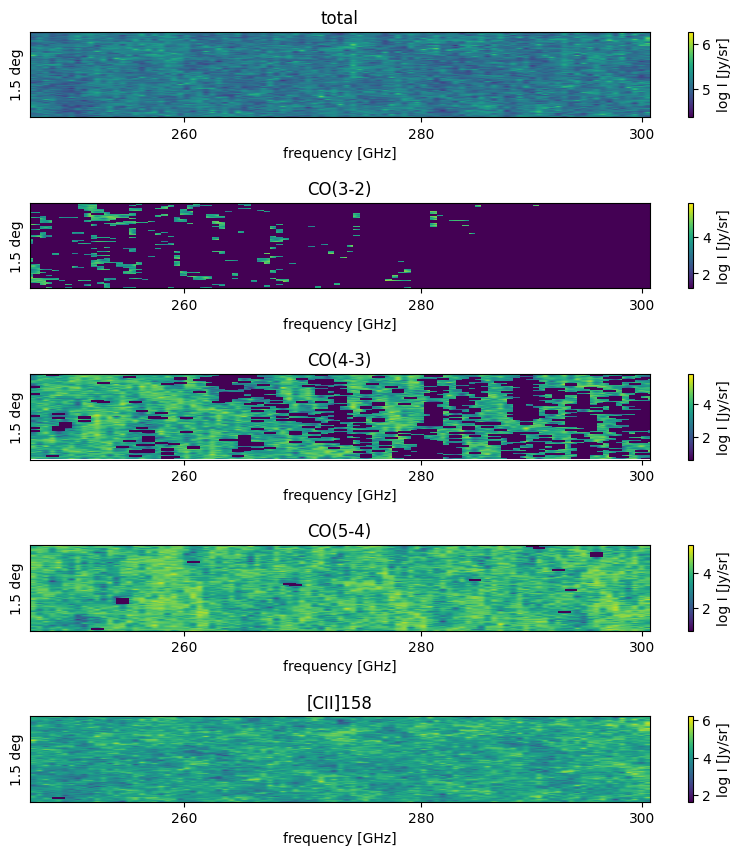

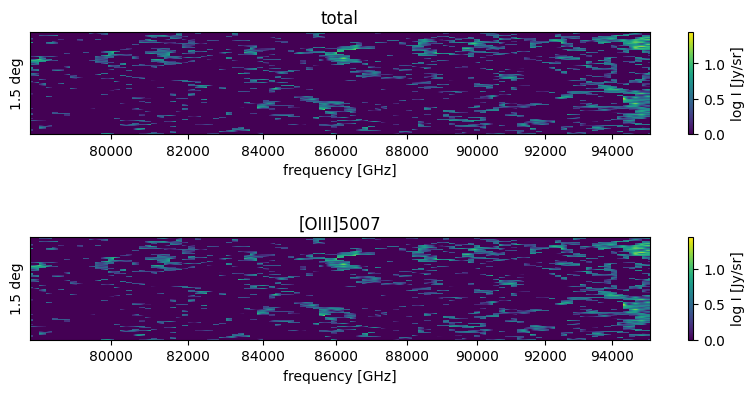

In [54]:
data_dir = "./output_TNG300-1"

freq, intensity, intensity_line = load_data(data_dir=data_dir, prefix="map", side_length=5400, fmin=248, fmax=301, dtheta=27, R=500, alpha=15)
show_map(freq, intensity, intensity_line, side_length=5400, lines_to_show=["CO(3-2)", "CO(4-3)", "CO(5-4)", "[CII]158"], dy=-1, use_log=True)

freq, intensity, intensity_line = load_data(data_dir=data_dir, prefix="nden_map", side_length=5400, fmin=78000, fmax=95100, dtheta=27, R=500, alpha=15)
show_map(freq, intensity, intensity_line, side_length=5400, lines_to_show=["[OIII]5007"], dy=-1, use_log=True)

### Voxel intensity distribution

In [ ]:
dtheta = 27
freq, intensity, intensity_line = load_data(data_dir=data_dir, side_length=5400, fmin=248, fmax=301, dtheta=dtheta, R=500)

int_min = 1 * (dtheta*arcsec)**2 * 1e3 
intensity = intensity.reshape(-1) 
intensity_line = intensity_line.reshape(NLINE, -1) 

intensity *= (dtheta*arcsec)**2 * 1e3 # [Jy/sr] -> [mJy]
intensity_line *= (dtheta*arcsec)**2 * 1e3 # [Jy/sr] -> [mJy]

plt.title("Voxel intensity distribution")

intensity = intensity[intensity > int_min]
plt.hist(np.log10(intensity), bins=50, color="k", label="total", histtype="step")
count = 0
for i in range(NLINE):
    if line_names[i] in ["CO(1-0)", "CO(2-1)", "CO(3-2)", "CO(4-3)", "CO(5-4)", "CO(6-5)", "CO(7-6)", "CO(8-7)", "CO(9-8)", "CO(10-9)", "CO(11-10)", "[CII]158", "[OIII]88", "[NII]205", "[NII]122"]:
        temp = intensity_line[i]
        temp = temp[temp > int_min]

        alpha = 0.5 if count < 10 else 1
        plt.hist(np.log10(temp), bins=50, alpha=alpha, label=line_names[i], histtype="step")
        count += 1

plt.xlabel("log I [mJy]")
plt.yscale("log")
plt.legend(bbox_to_anchor=(1,1.1))

### Visualize spectrum 

In [ ]:
dtheta = 10
freq, intensity, intensity_line = load_data(data_dir=data_dir, side_length=5400, fmin=248, fmax=301, dtheta=27, R=500)

intensity *= (dtheta*arcsec)**2 * 1e3 # [Jy/sr] -> [mJy]
intensity_line *= (dtheta*arcsec)**2 * 1e3 # [Jy/sr] -> [mJy]

lines_to_show = ["CO(5-4)", "CO(6-5)", "CO(7-6)", "[CII]158"]
Nmap = len(lines_to_show) + 1
for i in range(2):
    plt.figure(figsize=(10, Nmap*2))
    plt.subplots_adjust(hspace=0)
    plt.subplot2grid((Nmap,1),(0,0))
    plt.title("pixel size: 10 arcsec")
    plt.ylabel("I [mJy]")

    plt.plot(freq, intensity[i,0,:], label="total")
    plt.legend()
    count = 1
    for j in range(NLINE):
        if line_names[j] in lines_to_show:
            plt.subplot2grid((Nmap,1),(count,0))
            plt.ylabel("I [mJy]")
            plt.plot(freq, intensity_line[j][i,0,:], label=line_names[j])
            count += 1

            plt.legend()

    plt.xlabel("Frequency [GHz]")
            

In [ ]:
plt.figure()

x = np.linspace(0, 12, 1000)

plt.fill_between(x, 139, 170, color="orange", alpha=0.5)
plt.fill_between(x, 248, 301, color="orange", alpha=0.5)

for key, value in freq_rest_dict.items():
    if key == "CO(1-0)":
        continue
    if "[CI]" in key:
        continue
    if "[NII]" in key:
        continue

    f_obs = value / (1 + x)
    plt.plot(x, f_obs, label=key)

plt.xlabel("Redshift")
plt.ylabel("Frequency [GHz]")
plt.xlim([0, 12])
plt.ylim([130, 310])
plt.legend(bbox_to_anchor=(1,1.))

    

In [ ]:
def factor(z, alpha=3, z_middle=5):
    return (alpha - 1) * (0.5 * ( np.tanh( 0.5 * (z - z_middle) ) + 1 )) + 1

plt.figure()

data = np.loadtxt("./sfrd.txt")
z = data[:,0]
sfrd = data[:,1]

#plt.plot(z, sfrd * factor(z, alpha=10), label="more dust rich (alpha = 10)")
plt.plot(z, sfrd * factor(z), label="dust rich (alpha = 3)")
plt.plot(z, sfrd, label="original TNG300-1")
#plt.scatter(z, sfrd * factor(z, alpha=10), label="more dust rich (alpha = 10)")


plt.plot
plt.yscale("log")
plt.xlim([0, 12])
plt.ylim([2e-4, 0.3])
plt.grid()
plt.legend()
plt.xlabel("Redshift")
plt.ylabel(r"$\rm SFRD \ [M_\odot \ / \ yr\ / \ Mpc^3]$")


In [ ]:
## test scan speed
dtheta = 27
freq, intensity, intensity_line = load_data(data_dir=data_dir, side_length=5400, fmin=248, fmax=301, dtheta=dtheta, R=500)

index = 15
intensity_scan = intensity[:,index,40] * (dtheta*arcsec)**2 * 1e3 #[mJy]
x = np.linspace(0, len(intensity_scan), len(intensity_scan)) * dtheta 

plt.plot(x, intensity_scan)
plt.xlim([0, 200*dtheta])
plt.yscale("log")
plt.xlabel(r"$\theta \ \rm [arcsec]$")
plt.ylabel(f"intneisyt [mJy] ({freq[40]:.2f} GHz)")

plt.figure()

power = np.fft.fftshift(np.abs(np.fft.fft(intensity_scan))**2)
k = np.fft.fftshift(np.fft.fftfreq(len(intensity_scan), d=dtheta))
plt.plot(k, power)
plt.ylabel(r"$\rm power\ [mJy^2]$")
plt.xlabel(r"$f \rm \ [arcsec^{-1}]$")


In [ ]:
## test scan speed
dtheta = 27
freq, intensity, intensity_line = load_data(data_dir=data_dir, side_length=5400, fmin=248, fmax=301, dtheta=dtheta, R=500)

intensity_scan = intensity[:,10,40] * (dtheta*arcsec)**2 * 1e3 #[mJy]
x = np.linspace(0, len(intensity_scan), len(intensity_scan)) * dtheta 

plt.plot(x, intensity_scan)
plt.xlim([0, 200*dtheta])
#plt.yscale("log")
plt.xlabel(r"$\theta \ \rm [arcsec]$")
plt.ylabel(f"intneisyt [mJy] ({freq[40]:.2f} GHz)")

plt.figure()

power = np.fft.fftshift(np.abs(np.fft.fft(intensity_scan))**2)
k = np.fft.fftshift(np.fft.fftfreq(len(intensity_scan), d=dtheta))
plt.plot(k, power)
plt.ylabel(r"$\rm power\ [mJy^2]$")
plt.xlabel(r"$f \rm \ [arcsec^-1]$")
plt.yscale("log")
